# PHYS510 HW 5 - Central England Temperature
**By Philippe Nguyen**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Data Import & Management

I at first tried including 2017 data by using the mean of the monthly data so far (up to April), but the mean was much lower than the rest since half of it is wintertime, so I'll be excluding 2017 altogether.

In [36]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
cols = ['year'] + months + ['annual']
cetMax = pd.DataFrame(np.genfromtxt('cetMax.txt'), columns=cols)
cetMin = pd.DataFrame(np.genfromtxt('cetMin.txt'), columns=cols)

# Turn into monthly data
tMaxMonthly = np.array([[x for x in np.array(row[months])] for i, row in cetMax.iterrows()]).flatten()
tMinMonthly = np.array([[x for x in np.array(row[months])] for i, row in cetMin.iterrows()]).flatten()
idx = np.where(tMaxMonthly>-99)
yearsMonthly = np.arange(1878,2018.,1/12)[idx]
tMaxMonthly, tMinMonthly = [tMaxMonthly[idx], tMinMonthly[idx]]

# 2017 mean
# lastMax = cetMax.iloc[-1][months]
# cetMax.iloc[-1]['annual'] = lastMax[lastMax>-99].mean()
# lastMin = cetMin.iloc[-1][months]
# cetMin.iloc[-1]['annual'] = lastMin[lastMin>-99].mean()

# without 2017
cetMax2, cetMin2 = [cetMax, cetMin]
cetMax = cetMax[cetMax['year'] < 2017]
cetMin = cetMin[cetMin['year'] < 2017]

years = np.array(cetMax['year'])
tMax = np.array(cetMax['annual'])
tMin = np.array(cetMin['annual'])
# sdMax = [np.std(row[row>-99]) for idx, row in cetMax[months].iterrows()]
# sdMin = [np.std(row[row>-99]) for idx, row in cetMin[months].iterrows()]

# Smoothing

### Boxcar smoothing, 5-year width
This simply averages over a 5-year interval centered at each point.

In [4]:
def boxSmooth(x,y,width):
    a, b = [int(width/2), width-int(width/2)]
    return [np.mean(y[i-a:i+b]) for i in range(a, len(x)-a)]

### Gaussian smoothing, 7-year width
For each point, we convolve the full time series with a normalized Gaussian centered at that point, and average the result.

In [5]:
gaussian = lambda x, mu, sig: np.exp(-(x-mu)**2/(2*sig**2))
normGaussian = lambda x, mu, sig: gaussian(x,mu,sig)/(np.sum(gaussian(x,mu,sig)))
gSmooth = lambda x, y, width: [np.sum(y*normGaussian(x, i, width)) for i in x]

### Exponential smoothing
This is defined by
$$ s_0 = x_0 $$
$$ s_t = \alpha x_t + (1-\alpha) s_{t-1}, \ \ t>0 $$
where $\{x_i\}$ is the raw data set, $\{s_i\}$ the smoothed data set, and $\alpha$ the smoothing parameter, which ranges between 0 and 1. This parameter behaves like the inverse of the widths in the previous techniques, e.g. smaller $\alpha$ increases smoothing.

The $\alpha$ chosen in this example (0.3) is justified by a comparison of many $\alpha$ values later on.

In [6]:
def expSmooth(x,y,alpha):
    ySmooth = [y[0]]
    for i in range(1,len(x)):
        ySmooth.append(alpha*y[i] + (1-alpha)*ySmooth[i-1])
    return ySmooth

### Comparison of techniques

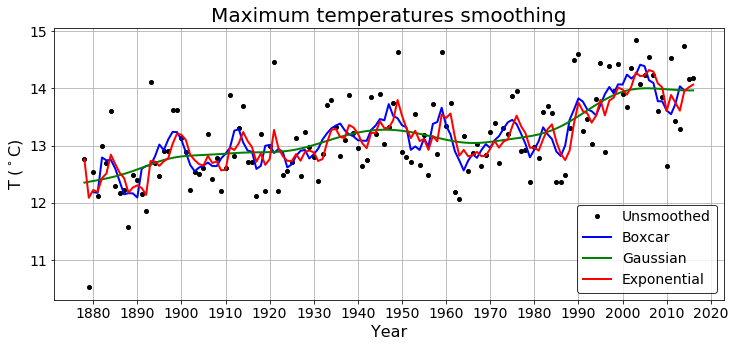

In [7]:
plt.figure(figsize=(12,5))
plt.plot(years, tMax, 'ko', markersize=4, label='Unsmoothed')
plt.plot(years[2:-2], boxSmooth(years,tMax,5), 'b-', lw=2, label='Boxcar')
plt.plot(years, gSmooth(years,tMax,7), 'g-', lw=2, label='Gaussian')
plt.plot(years, expSmooth(years, tMax, .3), 'r-', lw=2, label='Exponential')

plt.xticks(np.arange(1880,2021,10), size=14)
plt.yticks(size=14)
plt.title('Maximum temperatures smoothing', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('T ($^\circ$C)', size=16)

plt.legend(loc='lower right', fontsize=14, edgecolor='k')
plt.grid()
plt.show()

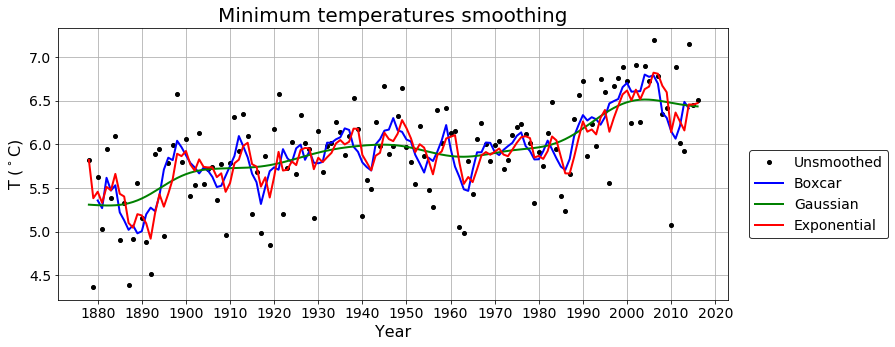

In [8]:
plt.figure(figsize=(12,5))
plt.plot(years, tMin, 'ko', markersize=4, label='Unsmoothed')
plt.plot(years[2:-2], boxSmooth(years, tMin, 5), 'b-', lw=2, label='Boxcar')
plt.plot(years, gSmooth(years, tMin, 7), 'g-', lw=2, label='Gaussian')
plt.plot(years, expSmooth(years, tMin, .3), 'r-', lw=2, label='Exponential')

plt.xticks(np.arange(1880,2021,10), size=14)
plt.yticks(size=14)
plt.title('Minimum temperatures smoothing', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('T ($^\circ$C)', size=16)

plt.legend(loc='lower right', fontsize=14, bbox_to_anchor=(1.25,.2), edgecolor='k')
plt.grid()
plt.show()

### Together (output for vizwall)

In [9]:
# Figure specs
fig = plt.figure()
my_dpi = float(fig.get_dpi())
scale = 11
fig.set_size_inches((scale*1000./my_dpi,scale*600./my_dpi))

# Plot features
plt.plot(years, tMax, 'ko', markersize=scale*3, label='Unsmoothed')
plt.plot(years[2:-2], boxSmooth(years,tMax,5), 'b-', lw=scale*1.5, label='Boxcar')
plt.plot(years, gSmooth(years,tMax,7), 'g-', lw=scale*1.5, label='Gaussian')
plt.plot(years, expSmooth(years,tMax,.3), 'r-', lw=scale*1.5, label='Exponential')

plt.plot(years, tMin, 'ko', markersize=scale*3)
plt.plot(years[2:-2], boxSmooth(years,tMin,5), 'b-', lw=scale*1.5)
plt.plot(years, gSmooth(years,tMin,7), 'g-', lw=scale*1.5)
plt.plot(years, expSmooth(years,tMin,.3), 'r-', lw=scale*1.5)

# Text
plt.title('Central England Temperature - smoothed data', size=scale*16, y=1.05)
plt.xlabel('Year', size=scale*14)
plt.ylabel('Temperature ($^\circ$C)', size=scale*14)
plt.annotate('Max temperatures', xy=(1910, 11.2), size=scale*12)
plt.annotate('Min temperatures', xy=(1905, 7.1), size=scale*12)

# Axes, other features
ax = plt.gca()
plt.xticks(np.arange(1880,2021,10), size=scale*12)
plt.yticks(np.arange(3,15.1,1), size=scale*12)
ax.tick_params(pad=scale*5)
ax.xaxis.set_label_coords(0.5, -0.07)
ax.yaxis.set_label_coords(-0.06, 0.5)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_linewidth(scale)
legend = plt.legend(loc='right', fontsize=scale*14, edgecolor='k')
legend.get_frame().set_linewidth(scale)
plt.grid(lw=scale*1)

plt.savefig('smoothing.png')
plt.close()

### Altogether, monthly data

In [6]:
# Figure specs
fig = plt.figure()
my_dpi = float(fig.get_dpi())
scale = 11
fig.set_size_inches((scale*1000./my_dpi,scale*600./my_dpi))

# Plot features
plt.plot(yearsMonthly, tMaxMonthly, 'ko', markersize=scale*3, label='Unsmoothed')
plt.plot(yearsMonthly[5:-5], boxSmooth(yearsMonthly,tMaxMonthly,11), 'b-', lw=scale*1.5, label='Boxcar')
plt.plot(yearsMonthly, gSmooth(yearsMonthly,tMaxMonthly,7/12), 'g-', lw=scale*1.5, label='Gaussian')
plt.plot(yearsMonthly, expSmooth(yearsMonthly,tMaxMonthly,.3/12), 'r-', lw=scale*1.5, label='Exponential')

# plt.plot(yearsMonthly, tMinMonthly, 'ko', markersize=scale*3)
# plt.plot(yearsMonthly[2:-2], boxSmooth(yearsMonthly,tMinMonthly,5), 'b-', lw=scale*1.5)
# plt.plot(yearsMonthly, gSmooth(yearsMonthly,tMinMonthly,7/12), 'g-', lw=scale*1.5)
# plt.plot(yearsMonthly, expSmooth(yearsMonthly,tMinMonthly/12,.3), 'r-', lw=scale*1.5)

# Text
plt.title('Central England Temperature - smoothed data', size=scale*16, y=1.05)
plt.xlabel('Year', size=scale*14)
plt.ylabel('Temperature ($^\circ$C)', size=scale*14)
# plt.annotate('Max temperatures', xy=(1910, 11.2), size=scale*12)
# plt.annotate('Min temperatures', xy=(1905, 7.1), size=scale*12)

# Axes, other features
ax = plt.gca()
plt.xticks(np.arange(1880,2021,10), size=scale*12)
# plt.yticks(np.arange(3,15.1,1), size=scale*12)
plt.yticks(size=scale*12)
ax.tick_params(pad=scale*5)
ax.xaxis.set_label_coords(0.5, -0.07)
ax.yaxis.set_label_coords(-0.06, 0.5)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_linewidth(scale)
legend = plt.legend(loc='right', fontsize=scale*14, edgecolor='k')
legend.get_frame().set_linewidth(scale)
plt.grid(lw=scale*1)

plt.savefig('smoothingMonthly.png')
plt.close()

# Varying the smoothing parameters

Out of curiosity, we can see how our choice of smoothing parameters affects our results. For the boxcar and Gaussian smoothing methods, greater widths will give smoother outcomes but at the cost of suppressing behavior at shorter time scales. With exponential smoothing, the $\alpha$ parameter has the opposite effect; smoothing is improved for greater $\alpha$.

### Boxcar

In [20]:
colors = ['b', 'r', 'g', 'm']
widths = [3,5,7,9]

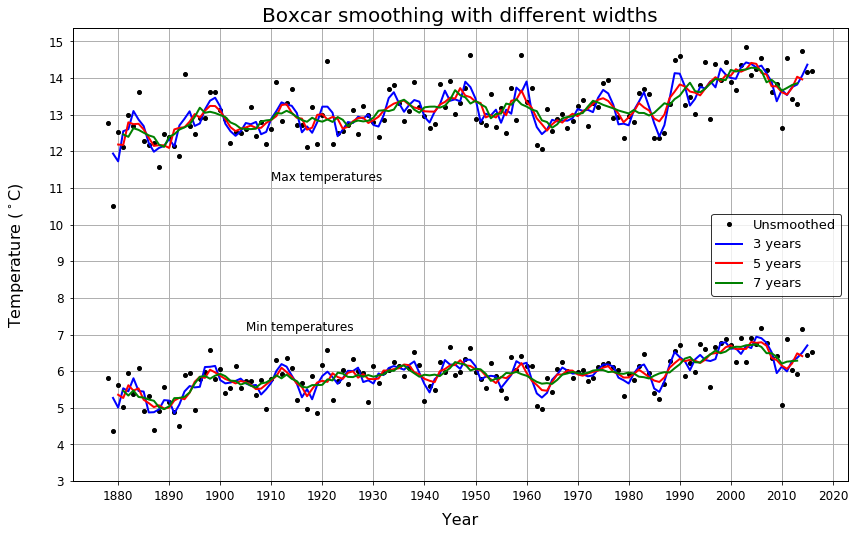

In [10]:
fig = plt.figure()
my_dpi = float(fig.get_dpi())
scale = 1
fig.set_size_inches((scale*1000./my_dpi,scale*600./my_dpi))

plt.plot(years, tMax, 'ko', markersize=4, label='Unsmoothed')
for i in range(3):
    plt.plot(years[int(widths[i]/2):-int(widths[i]/2)], 
             boxSmooth(years,tMax,widths[i]), colors[i]+'-', lw=2, 
             label='{} years'.format(widths[i]))
plt.plot(years, tMin, 'ko', markersize=4)
for i in range(3):
    plt.plot(years[int(widths[i]/2):-int(widths[i]/2)], 
             boxSmooth(years,tMin,widths[i]), colors[i]+'-', lw=2)

    
plt.title('Boxcar smoothing with different widths', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('Temperature ($^\circ$C)', size=16)
plt.annotate('Max temperatures', xy=(1910, 11.2), size=scale*12)
plt.annotate('Min temperatures', xy=(1905, 7.1), size=scale*12)

ax = plt.gca()
plt.xticks(np.arange(1880,2021,10), size=scale*12)
plt.yticks(np.arange(3,15.1,1), size=scale*12)
ax.tick_params(pad=scale*5)
ax.xaxis.set_label_coords(0.5, -0.07)
ax.yaxis.set_label_coords(-0.06, 0.5)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_linewidth(scale)
legend = plt.legend(loc='right', fontsize=scale*13, edgecolor='k')
legend.get_frame().set_linewidth(scale)
plt.grid(lw=scale*1)

# plt.savefig('boxcar.png')
# plt.close()

plt.show()

### Gaussian
This is by far the smoothest technique, almost regardless of our width-selection. At a glance this also seems to be a really good method for isolating trends by time-scale. Looking at the 3-year-smoothing, for instance, shows some possible periodicity on the scale of 5-10 years. This behavior is *present yet unobvious* in the 5-year boxcar smoothing and the $\alpha=0.3$ exponential smoothing, while this 3-year Gaussian makes it clear as day.

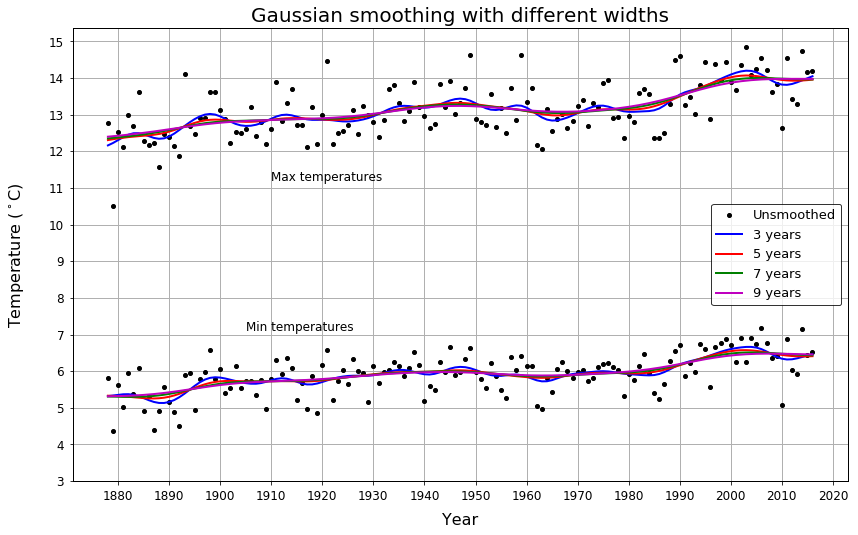

In [11]:
fig = plt.figure()
my_dpi = float(fig.get_dpi())
scale = 1
fig.set_size_inches((scale*1000./my_dpi,scale*600./my_dpi))

plt.plot(years, tMax, 'ko', markersize=4, label='Unsmoothed')
for i in range(4):
    plt.plot(years, gSmooth(years,tMax,widths[i]), colors[i]+'-', lw=2, 
             label='{} years'.format(widths[i]))
plt.plot(years, tMin, 'ko', markersize=4)
for i in range(4):
    plt.plot(years, gSmooth(years,tMin,widths[i]), colors[i]+'-', lw=2)

    
plt.title('Gaussian smoothing with different widths', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('Temperature ($^\circ$C)', size=16)
plt.annotate('Max temperatures', xy=(1910, 11.2), size=scale*12)
plt.annotate('Min temperatures', xy=(1905, 7.1), size=scale*12)

ax = plt.gca()
plt.xticks(np.arange(1880,2021,10), size=scale*12)
plt.yticks(np.arange(3,15.1,1), size=scale*12)
ax.tick_params(pad=scale*5)
ax.xaxis.set_label_coords(0.5, -0.07)
ax.yaxis.set_label_coords(-0.06, 0.5)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_linewidth(scale)
legend = plt.legend(loc='right', fontsize=scale*13, edgecolor='k')
legend.get_frame().set_linewidth(scale)
plt.grid(lw=scale*1)

# plt.savefig('gauss.png')
# plt.close()

plt.show()

### Exponential

The choice of $\alpha=0.3$ before seems reasonable based on the plot below. With $\alpha=0.1$, the smoothing is too strong and we lose all the interesting features, while $\alpha=0.5$ seems hardly better than the crude boxcar method.

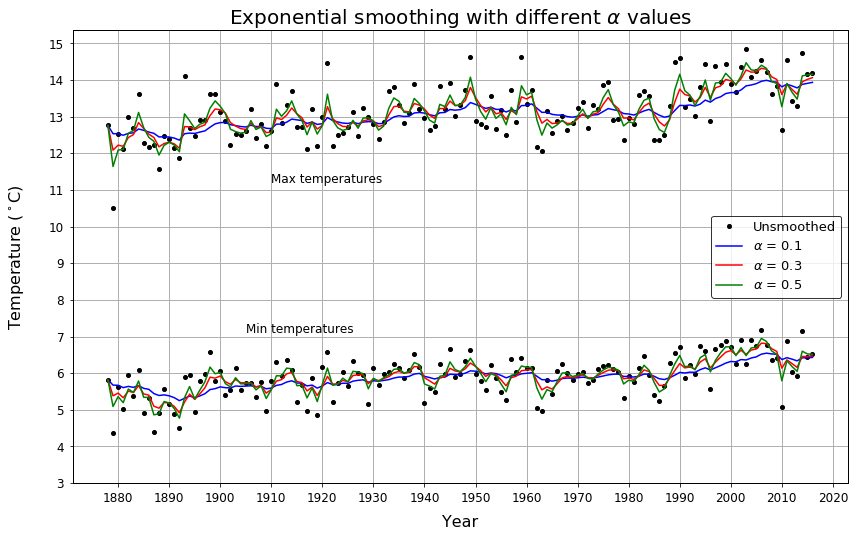

In [12]:
alphas = [.1,.3,.5,.7,.9]

fig = plt.figure()
my_dpi = float(fig.get_dpi())
scale = 1
fig.set_size_inches((scale*1000./my_dpi,scale*600./my_dpi))

plt.plot(years, tMax, 'ko', markersize=4, label='Unsmoothed')
for i in range(3):
    plt.plot(years, expSmooth(years,tMax,alphas[i]), colors[i]+'-', lw=1.5, 
             label=r'$\alpha$ = {}'.format(alphas[i]))
plt.plot(years, tMin, 'ko', markersize=4)
for i in range(3):
    plt.plot(years, expSmooth(years,tMin,alphas[i]), colors[i]+'-', lw=1.5)

    
plt.title(r'Exponential smoothing with different $\alpha$ values', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('Temperature ($^\circ$C)', size=16)
plt.annotate('Max temperatures', xy=(1910, 11.2), size=scale*12)
plt.annotate('Min temperatures', xy=(1905, 7.1), size=scale*12)

ax = plt.gca()
plt.xticks(np.arange(1880,2021,10), size=scale*12)
plt.yticks(np.arange(3,15.1,1), size=scale*12)
ax.tick_params(pad=scale*5)
ax.xaxis.set_label_coords(0.5, -0.07)
ax.yaxis.set_label_coords(-0.06, 0.5)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_linewidth(scale)
legend = plt.legend(loc='right', fontsize=scale*13, edgecolor='k')
legend.get_frame().set_linewidth(scale)
plt.grid(lw=scale*1)

# plt.savefig('exp.png')
# plt.close()

plt.show()

# Annual temperature anomaly

In [13]:
maxBase1 = np.mean(cetMax[(cetMax['year']>=1961) & (cetMax['year']<=1990)]['annual'])
maxBase2 = np.mean(cetMax[(cetMax['year']>=1880) & (cetMax['year']<=1980)]['annual'])

minBase1 = np.mean(cetMin[(cetMin['year']>=1961) & (cetMin['year']<=1990)]['annual'])
minBase2 = np.mean(cetMin[(cetMin['year']>=1880) & (cetMin['year']<=1980)]['annual'])

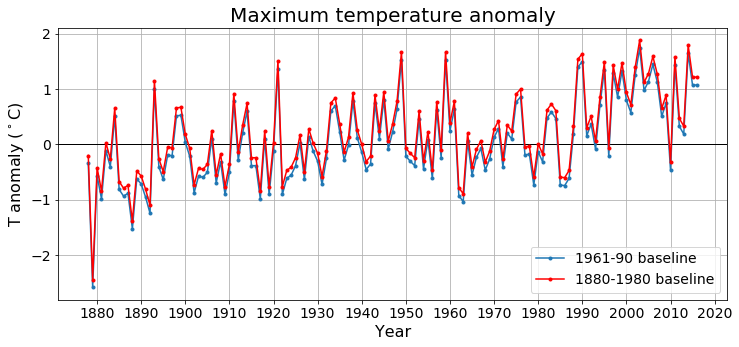

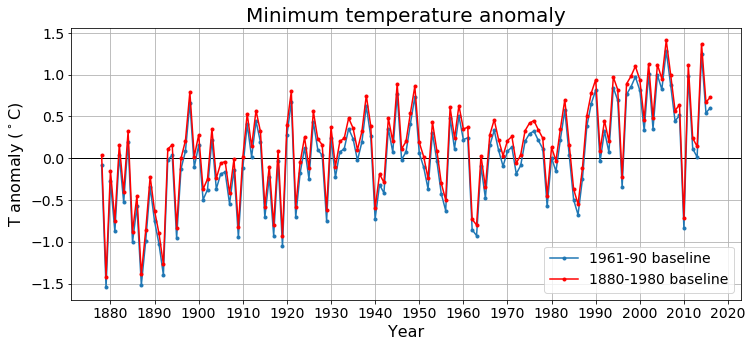

In [14]:
plt.figure(figsize=(12,5))
plt.axhline(y=0, c='k', lw=1)
plt.plot(years, tMax-maxBase1, '.-', label='1961-90 baseline')
plt.plot(years, tMax-maxBase2, 'r.-', label='1880-1980 baseline')

plt.xticks(np.arange(1880,2021,10), size=14)
plt.yticks(size=14)
plt.title('Maximum temperature anomaly', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('T anomaly ($^\circ$C)', size=16)

plt.legend(loc='lower right', fontsize=14)
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.axhline(y=0, c='k', lw=1)
plt.plot(years, tMin-minBase1, '.-', label='1961-90 baseline')
plt.plot(years, tMin-minBase2, 'r.-', label='1880-1980 baseline')

plt.xticks(np.arange(1880,2021,10), size=14)
plt.yticks(size=14)
plt.title('Minimum temperature anomaly', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('T anomaly ($^\circ$C)', size=16)

plt.legend(loc='lower right', fontsize=14)
plt.grid()
plt.show()

In [7]:
def best_baseline(df, column, steps):
    """Determine 'best' baseline, which maximizes the average temperature anomaly over 2007-2016"""
    yStart = df['year'].min()
    yEnd = df['year'].max()
    base_best = [df[column].mean(), yStart, yEnd]
    x = df[df['year']>=2007][column].mean()
    i=0
    while i <= steps:
        y1, y2 = np.sort(np.random.randint(yStart, yEnd+1, 2))
        if y2-y1 >= 30:
            base = df[(df['year']>=y1) & (df['year']<=y2)][column].mean()
            if base < base_best[0]:
                base_best = [base, y1, y2]
            i += 1
    return base_best

Best baseline for max temperatures
start year: 1879
end year: 1909
Baseline = 12.60 deg C


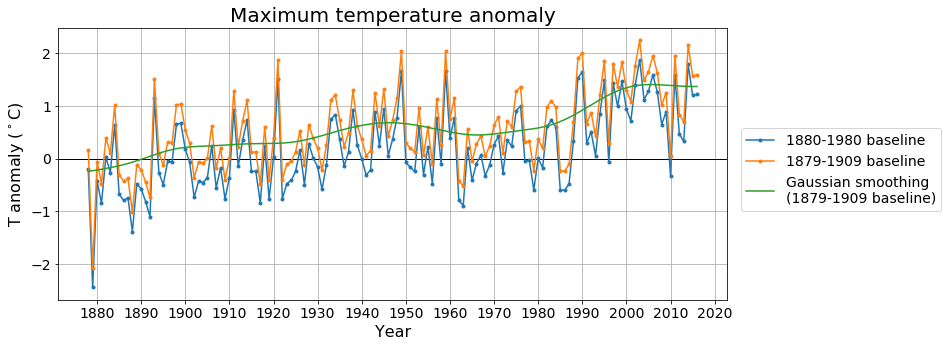

In [16]:
maxBaseBest, yMax1, yMax2 = best_baseline(cetMax, 'annual', 1000)
print('Best baseline for max temperatures\nstart year: {:.0f}\nend year: {:.0f}'.format(yMax1,yMax2))
print('Baseline = {:.2f} deg C'.format(maxBaseBest))

plt.figure(figsize=(12,5))
plt.axhline(y=0, lw=1, color='k')
plt.plot(years, tMax-maxBase2, '.-', label='1880-1980 baseline')
plt.plot(years, tMax-maxBaseBest, '.-', label='{:.0f}-{:.0f} baseline'.format(yMax1, yMax2))
# Gaussian smoothing
plt.plot(years, gSmooth(years, tMax-maxBaseBest, 7), '-', 
         label='Gaussian smoothing\n({:.0f}-{:.0f} baseline)'.format(yMax1, yMax2))

plt.xticks(np.arange(1880,2021,10), size=14)
plt.yticks(size=14)
plt.title('Maximum temperature anomaly', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('T anomaly ($^\circ$C)', size=16)

plt.legend(loc='lower right', fontsize=14, bbox_to_anchor=(1.33,.3))
plt.grid()
plt.show()

Best baseline for max temperatures
start year: 1879
end year: 1909
Baseline = 5.46 deg C


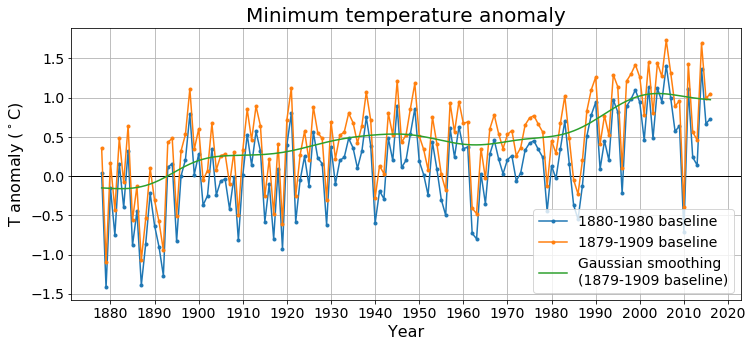

In [17]:
minBaseBest, yMin1, yMin2 = best_baseline(cetMin, 'annual', 10000)
print('Best baseline for max temperatures\nstart year: {:.0f}\nend year: {:.0f}'.format(yMin1,yMin2))
print('Baseline = {:.2f} deg C'.format(minBaseBest))

plt.figure(figsize=(12,5))
plt.axhline(y=0, lw=1, color='k')
plt.plot(years, tMin-minBase2, '.-', label='1880-1980 baseline')
plt.plot(years, tMin-minBaseBest, '.-', label='{:.0f}-{:.0f} baseline'.format(yMin1, yMin2))
# Gaussian smoothing
plt.plot(years, gSmooth(years, tMin-minBaseBest, 7), '-', 
         label='Gaussian smoothing\n({:.0f}-{:.0f} baseline)'.format(yMin1, yMin2))

plt.xticks(np.arange(1880,2021,10), size=14)
plt.yticks(size=14)
plt.title('Minimum temperature anomaly', size=20)
plt.xlabel('Year', size=16)
plt.ylabel('T anomaly ($^\circ$C)', size=16)

plt.legend(loc='lower right', fontsize=14)
plt.grid()
plt.show()

### Comparison of results

In [18]:
print('Mean anomaly of 2007-2016 maximum temperatures:')
print('1880-1980 baseline: {:.2f} deg C'.format((cetMax[cetMax['year']>=2007]['annual']-maxBase2).mean()))
print('{:.0f}-{:.0f} baseline: {:.2f} deg C'.format(yMax1, yMax2, (cetMax[cetMax['year']>=2007]['annual']-maxBaseBest).mean()))

print('\nMean anomaly of 2007-2016 minimum temperatures:')
print('1880-1980 baseline: {:.2f} deg C'.format((cetMin[cetMin['year']>=2007]['annual']-minBase2).mean()))
print('{:.0f}-{:.0f} baseline: {:.2f} deg C'.format(yMin1, yMin2, (cetMin[cetMin['year']>=2007]['annual']-minBaseBest).mean()))

Mean anomaly of 2007-2016 maximum temperatures:
1880-1980 baseline: 0.91 deg C
1879-1909 baseline: 1.27 deg C

Mean anomaly of 2007-2016 minimum temperatures:
1880-1980 baseline: 0.58 deg C
1879-1909 baseline: 0.90 deg C


We can see that our baseline choices significantly increased the 2007-2016 mean anomaly from what we had with the 100-year baseline. The max-temp data was affected just a tiny bit more, probably due to the overall higher numbers. We should probably use that data set for our climate policy pitch.

# Monthly temperature anomaly

In [19]:
monthly = {month: np.array(cetMax[month]) for month in months}

fig, axarr = plt.subplots(4,3)
fig.set_size_inches(15,20)
for i in range(12):
#     plt.subplot(4,3,i+1)
#     print(int(i/3), i%3)
    axarr[int(i/3), i%3].plot(years, monthly[months[i]], 'k.')
    for w in [5,7,9,11]:
        axarr[int(i/3), i%3].plot(years, gSmooth(years, monthly[months[i]], w), '-')
    axarr[int(i/3), i%3].set_title(months[i])
    axarr[int(i/3), i%3].grid()

plt.close()

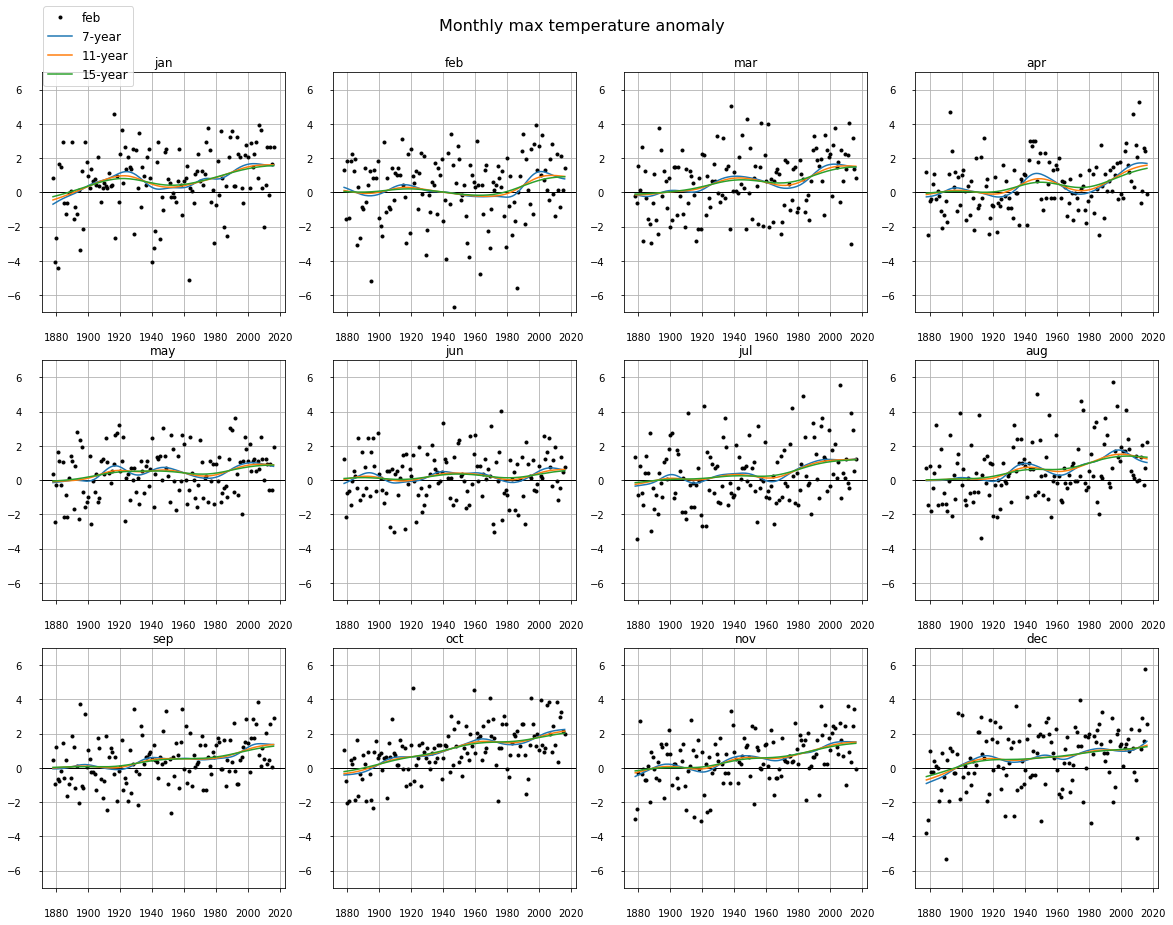

In [32]:
fig, axarr = plt.subplots(3,4)
fig.set_size_inches(20,15)
fig.suptitle('Monthly max temperature anomaly', size=16, y=0.93)
maxMonthlyBaseBest, yMax1, yMax2 = best_baseline(cetMax, 'annual', 1000)
for i in range(12):
    ax_i = axarr[int(i/4), i%4]
    ax_i.axhline(y=0, c='k', lw=1)
#     maxMonthlyBaseBest, yMax1, yMax2 = best_baseline(cetMax, months[i], 100)
    maxMonthlyBaseBest = cetMax[(cetMax['year']>=yMax1) & (cetMax['year']<=yMax2)][months[i]].mean()
    ax_i.plot(years, cetMax[months[i]]-maxMonthlyBaseBest, 'k.')
    for w in [7,11,15]:
        ax_i.plot(years, gSmooth(years, cetMax[months[i]]-maxMonthlyBaseBest, w), '-', 
                  label='{}-year'.format(w))
    ax_i.set_title(months[i])
    ax_i.set_ylim(-7,7)
    ax_i.tick_params(pad=scale*1.5)
    ax_i.grid()
    if i == 1:
        ax_i.legend(bbox_to_anchor=(-.8,1.3), fontsize=12)

plt.show()

In [24]:
colors = ['b', 'r', 'g']
widths = [11,7,3]

In [51]:
maxMonthlyBaseBest, yMax1, yMax2 = best_baseline(cetMax, 'annual', 1000)

fig = plt.figure()

fig, axarr = plt.subplots(3,4)
my_dpi = float(fig.get_dpi())
scale = 11
fig.set_size_inches((scale*1600./my_dpi,scale*900./my_dpi))
fig.suptitle('Monthly max temperature anomaly ($^\circ$C)\nwith Gaussian smoothing', size=scale*16, y=0.96)
for i in range(12):
    ax_i = axarr[int(i/4), i%4]
    if months[i] in ['jan', 'feb', 'mar', 'apr']:
        x = np.append(years, 2017.)
        df = cetMax2
    else:
        x = years
        df = cetMax
    ax_i.axhline(y=0, c='k', lw=scale*1)
#     maxMonthlyBaseBest, yMax1, yMax2 = best_baseline(cetMax, months[i], 100)
    maxMonthlyBaseBest = df[(df['year']>=yMax1) & (df['year']<=yMax2)][months[i]].mean()
    ax_i.plot(x, df[months[i]]-maxMonthlyBaseBest, 'ko', markersize=scale*2, label='Unsmoothed')
    for j in range(3):
        ax_i.plot(x, gSmooth(x, df[months[i]]-maxMonthlyBaseBest, widths[j]), '-', 
                  lw=scale*1.5, color=colors[j], label='{}-year'.format(widths[j]))
    ax_i.set_title(months[i], size=scale*14, y=1.02)
    ax_i.set_ylim(-7,7)
    ax_i.set_yticks(np.arange(-6,6.1,1))
    for tick in ax_i.yaxis.get_major_ticks():
        tick.label.set_fontsize(scale*8)
    for tick in ax_i.xaxis.get_major_ticks():
        tick.label.set_fontsize(scale*8)
    ax_i.tick_params(pad=scale*1.5)
    ax_i.grid(lw=scale*1)
    for side in ['top', 'bottom', 'left', 'right']:
        ax_i.spines[side].set_linewidth(scale)
    if i == 1:
        legend = ax_i.legend(bbox_to_anchor=(-.8,1.4), fontsize=scale*10)
        legend.get_frame().set_linewidth(scale*.8)

plt.savefig('monthlyAnomaly.png')
plt.close()